In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set


The training dataset used for this task is the [Omniglot dataset](https://github.com/brendenlake/omniglot), which contains images of handwritten characters of size (28,28). 

For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

In [2]:
train_data = np.load('train_data.npy', mmap_mode='r')
train_label = np.load('train_label.npy', mmap_mode='r')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



The first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that the model should be able to recognize as the same class as the query image. 

In [3]:
import matplotlib.pyplot as plt

def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    """
    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))

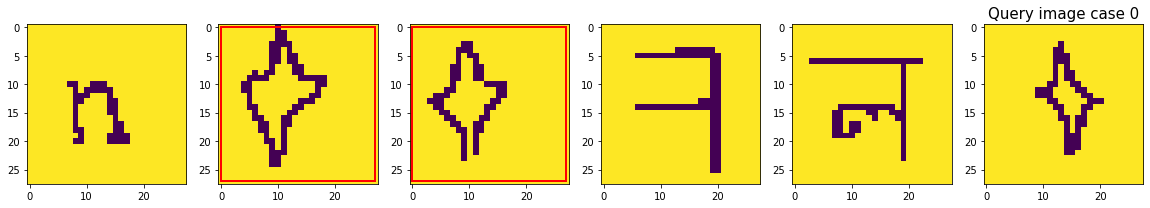

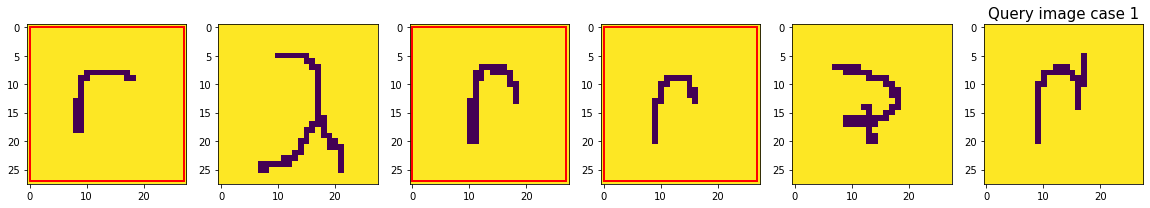

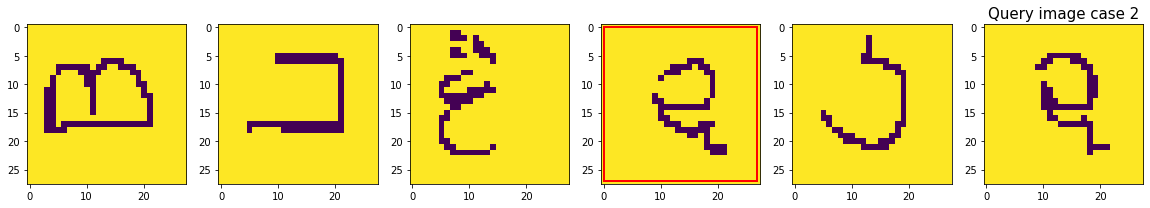

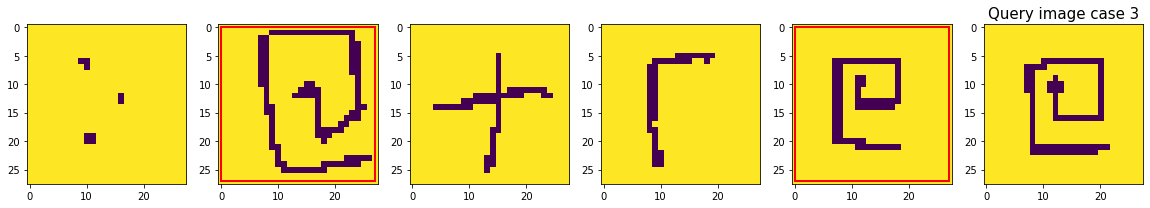

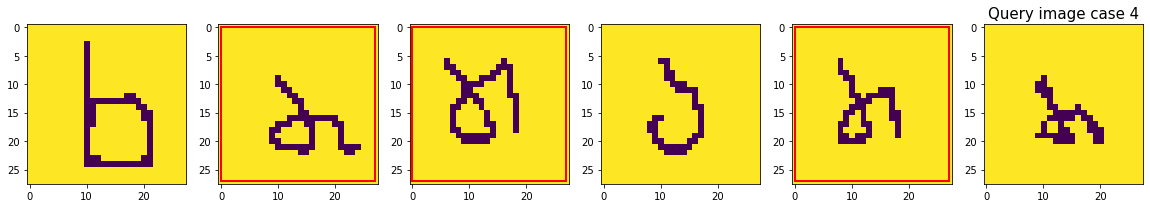

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

The query data set contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set.

In [5]:
test_data = np.load('test_data.npy', mmap_mode='r')
test_label = np.load('test_label.npy', mmap_mode='r')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



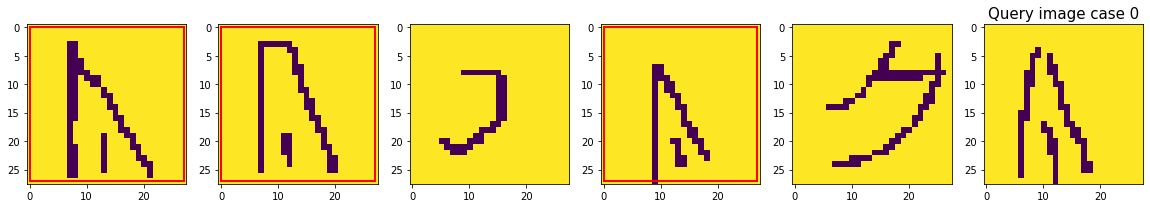

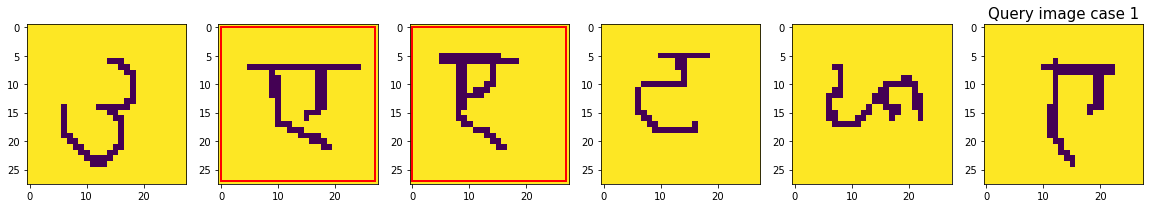

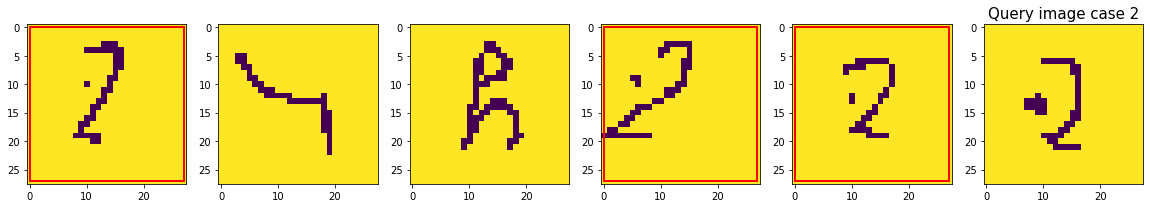

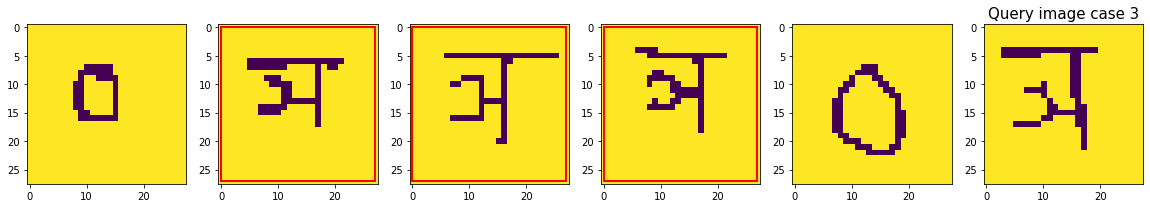

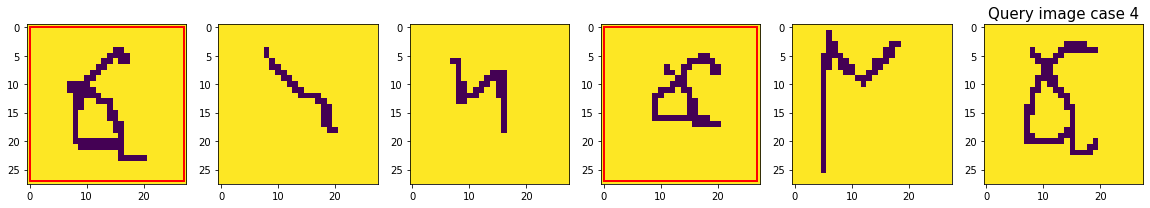

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

## Problem Formulation

Need to predict whether the given support images belong to the same class as a given query image. Given 5 support images, $(x_0, . . . , x_4)$ and 1 query image $x_q$, we want to predict whether any of the $x_i$ images for $i = 0, . . . , 4$ belong to the same class as $x_q$. Thus, we want to model $f(x_i, x_q) ∈ {1, 0}$ for $i = 0, . . . , 4$. Here, $f(x_i, x_q) = 1$ denotes that image $x_i$ belongs to the same class as the query image, $x_q$. Otherwise, $f(x_i, x_q) = 0$. This problem is an example of image retrieval. To solve it, an embedding for the images needs to be created and used to make the actual predictions. Image embeddings represent images in dense vectors that can be generated using Convolutional Neural Networks. They are suitable for this task as they allow to compute the similarity between them. The prediction could be made by utilizing the distances between the embedding of a query image and the support images. A good measure of performance for our solution could be to compare if the distances of between embeddings of images that match the query image and the embedding of the query image. If the distance between two embeddings is small, then the images likely belong to the same class.

### Build pytorch dataset and dataloader

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)
  
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
test_dataset = MyDataset(test_data,test_label)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

C:\Users\t1rk9\AppData\Local\Temp/ipykernel_5916/3606015883.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  self.data = torch.FloatTensor(data)


To generate triples for the triplet loss, class TripleData is used. For every set of images in the training dataset, the first five images are the support images and the last sixth image is the query image which will be our anchor image. From the support images, the indices of the images that correspond to the same class as the query image (positive indexes) and the indices of the images that does not correspond to the same class as the query image (negative indexes) are obtained. Then one positive and one negative index are randomly choosen.The anchor image together with the support image belonging to the positive class and the support image belonging to the negative class are returned.

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image
import random


class TripleData(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

        
    def __getitem__(self, index):
        support_images, anchor_image = self.data[index, 0:5], self.data[index, 5]
        positive_image_indexes = np.where(self.labels[index] == 1)[0]
        negative_image_indexes = np.where(self.labels[index] == 0)[0]
        positive_index = np.random.choice(positive_image_indexes)
        negative_index = np.random.choice(negative_image_indexes)
        return [anchor_image, support_images[positive_index], support_images[negative_index]]
    
    def __len__(self):
        return len(self.data)

In [10]:
train_triple_data = TripleData(train_data,train_label)
train_loader = torch.utils.data.DataLoader(train_triple_data, batch_size=10)

### Build CNN model

CNNs are useful in our task because of the nature of the data. They can detect spatially localized features (patterns) in the images. By learning individual edges, the CNN can combine them to learn more spread out patterns. Additionally, convolutional layers incorporate translational symmetry as features on images (grids) are symmetric to translation.

The convolutional layers used kernel size set to 3 to influence the model to generalize better, and padding set to 1. The max pooling layers used kernel size and stride set to 2 as they should not be large. Max pooling was used to reduce the resolution of the input images. For regularization we used batch normalization. The ReLU activation function was used to reduce the computation cost of the network. The number of channels after each convolutional layer is doubled to allow the network to learn more complex features in the deeper layers.

In [11]:
import torch.nn as nn

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
  
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(2304, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        x = x.view(-1, 1, 28, 28)
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

### Triplet Loss for One-Shot Learning

### Triplet loss objective: $L(x_p, x_n, x_a) = max(|f(x_a) - f(x_p)|^2_2 - |f(x_a) - f(x_n)|^2_2 + \alpha, 0)$

$x_p$ and $x_a$ are images from the positive class, $x_n$ is an image from a different class and $x_a$ is our query image $x_q$. Additionally, $f(x)$ denotes the embedding of image $x$ and $\alpha$ denotes the margin between the difference of $x_p$ and $x_a$ and $x_n$ and $x_a$. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value. Thus triplet loss is suitable as, the distance between the embeddings of similar images should be small, while the distance between embeddings of different images should be large.

In [12]:
class TripletLoss(nn.Module):
    """
    Calculate the Triplets loss for the model, by passing an anchor, a positive, and a negative image embedding
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses)

### Training

In [13]:
import numpy as np
from tqdm import tqdm

trained_loss_values = []


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_losses=[]
            
            for batch in self.training_DataLoader:
                anchor, positive, negative = batch
                # send to device (GPU or CPU)
                embedding_anchor = model(anchor.to(device))
                embedding_positive = model(positive.to(device))
                embedding_negative = model(negative.to(device))   
                self.optimizer.zero_grad()  # zerograd the parameters

                loss = self.criterion(embedding_anchor, embedding_positive, embedding_negative)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
                
            # print the results
            trained_loss_values.append(np.mean(train_losses))
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')

In [14]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
cnn = CNN()
model = cnn.to(device)

# margin value
margin=1

# criterion
criterion = TripletLoss(margin)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  validation_DataLoader=test_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|████████▎                                                                          | 1/10 [00:23<03:29, 23.27s/it]

EPOCH: 01/10 LOSS: 0.3643 

 20%|████████████████▌                                                                  | 2/10 [00:42<02:47, 20.97s/it]

EPOCH: 02/10 LOSS: 0.1599 

 30%|████████████████████████▉                                                          | 3/10 [01:02<02:23, 20.47s/it]

EPOCH: 03/10 LOSS: 0.1050 

 40%|█████████████████████████████████▏                                                 | 4/10 [01:22<02:02, 20.34s/it]

EPOCH: 04/10 LOSS: 0.0861 

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:42<01:41, 20.30s/it]

EPOCH: 05/10 LOSS: 0.0729 

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:02<01:20, 20.22s/it]

EPOCH: 06/10 LOSS: 0.0594 

 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:22<00:59, 19.93s/it]

EPOCH: 07/10 LOSS: 0.0589 

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:41<00:39, 19.72s/it]

EPOCH: 08/10 LOSS: 0.0462 

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:00<00:19, 19.60s/it]

EPOCH: 09/10 LOSS: 0.0367 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:20<00:00, 20.05s/it]

EPOCH: 10/10 LOSS: 0.0412 

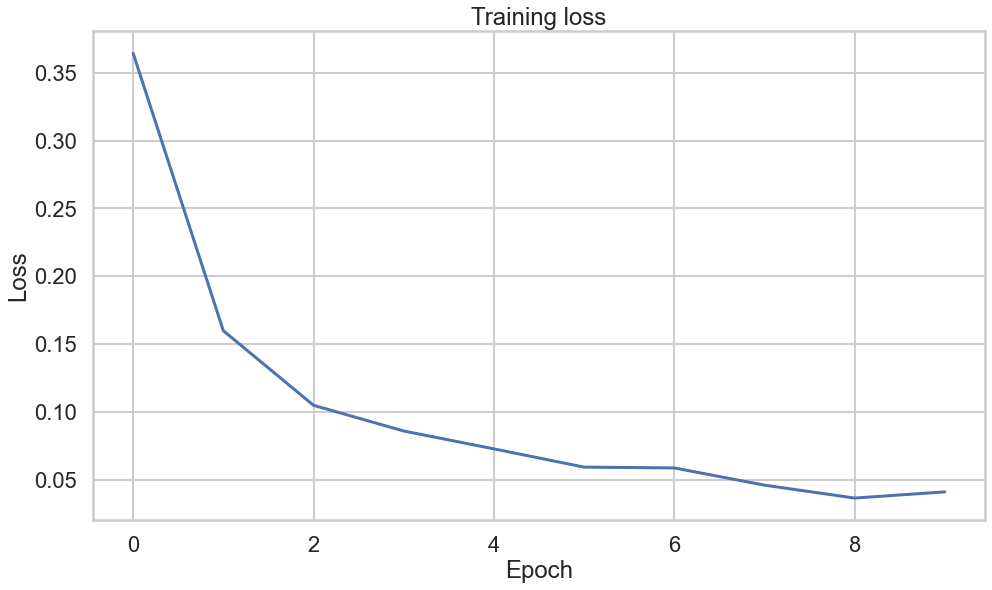

In [15]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_style("whitegrid")
sns.set_context("poster")
# Plot trained loss values
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(trained_loss_values)
ax.set_title('Training loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
# plt.savefig('training_loss.png')
plt.show()

### Evaluation

The used metrics for evaluation are accuracy, precision, recall, and F1 score. Additionally, the mistakes that the model makes are investigated. For the first 20 query sets the truth labels are printed and the set of images, where the 1st images is the query image and the rest are the support images are plotted. Support images predicted correctly have a red border.

#### FIRST OPTION OF PREDICTION THRESHOLD: maximum of all positive distances

Truth: tensor([1, 1, 0, 1, 0])


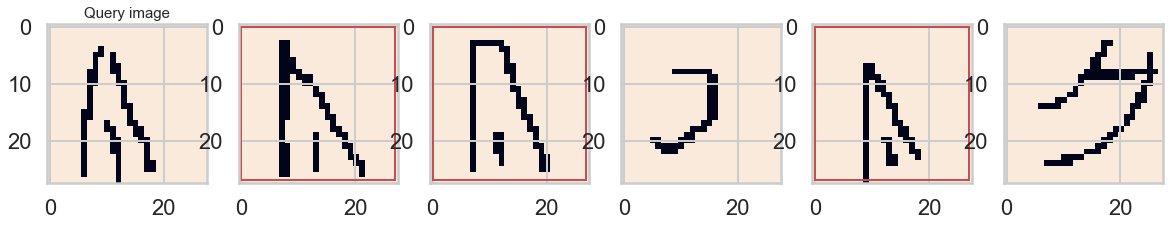

Truth: tensor([0, 1, 1, 0, 0])


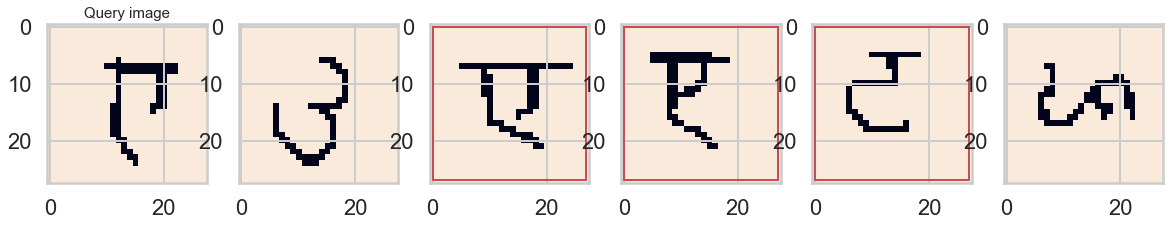

Truth: tensor([0, 0, 1, 1, 1])


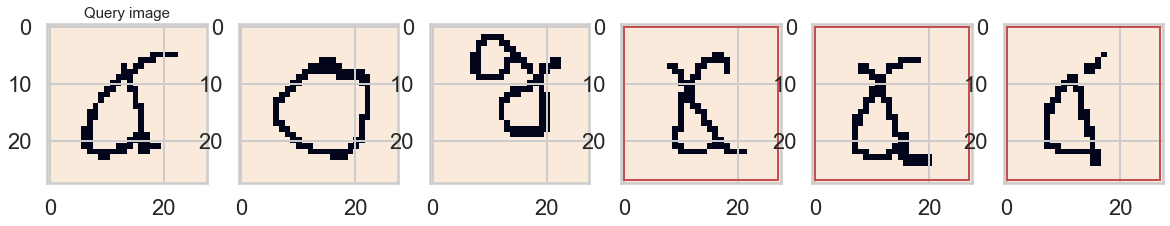

Truth: tensor([0, 1, 0, 1, 1])


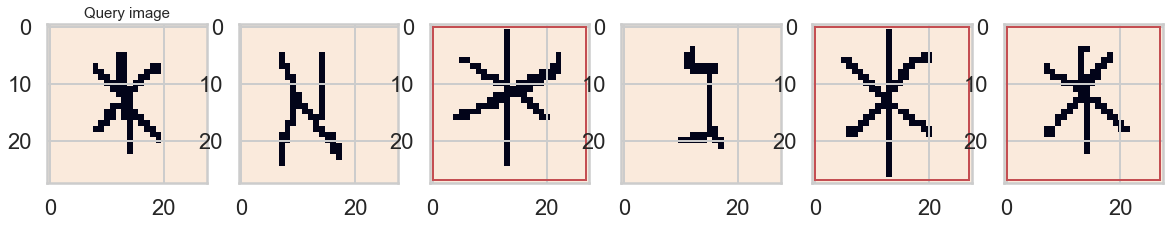

Truth: tensor([1, 0, 0, 0, 0])


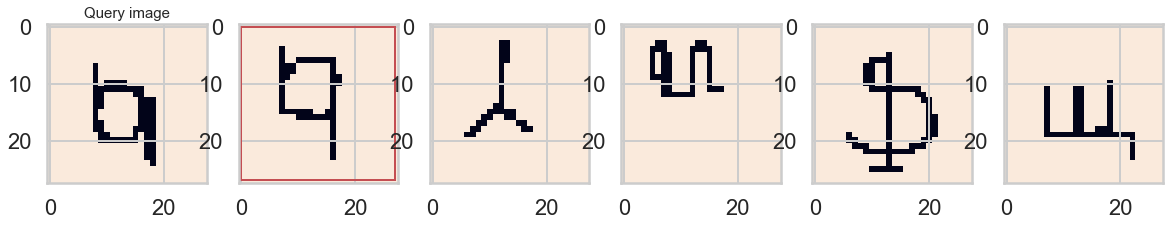

Truth: tensor([1, 0, 1, 1, 0])


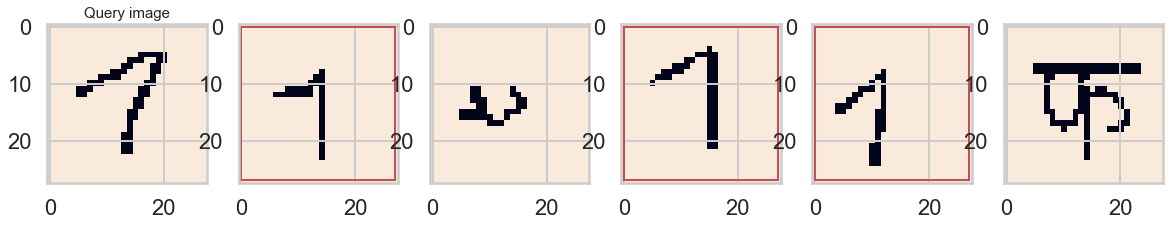

Truth: tensor([1, 0, 1, 0, 0])


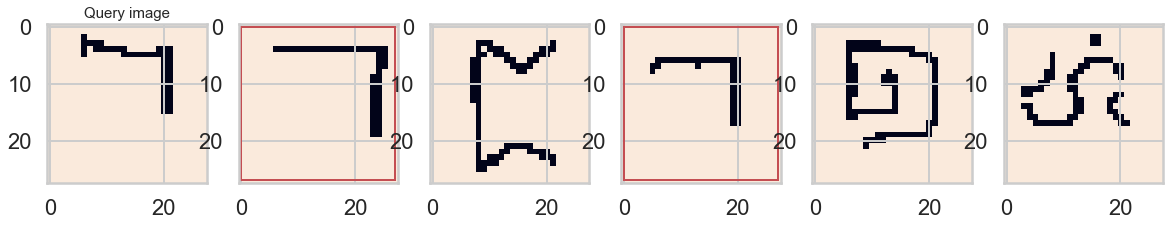

Truth: tensor([1, 1, 1, 0, 0])


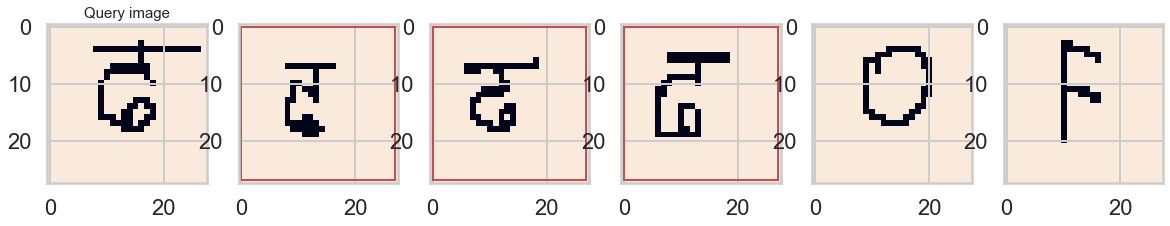

Truth: tensor([0, 0, 1, 0, 1])


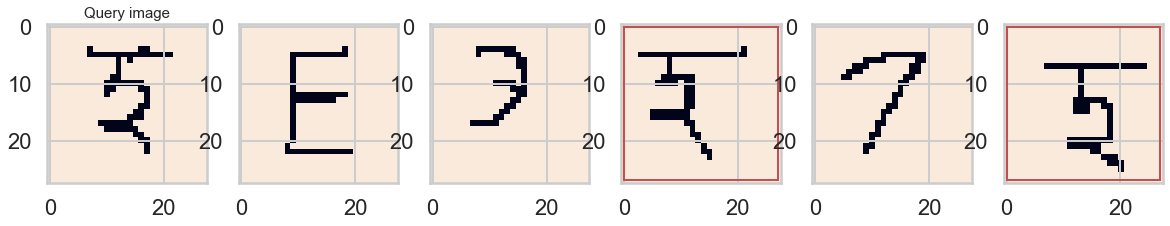

Truth: tensor([0, 0, 1, 1, 1])


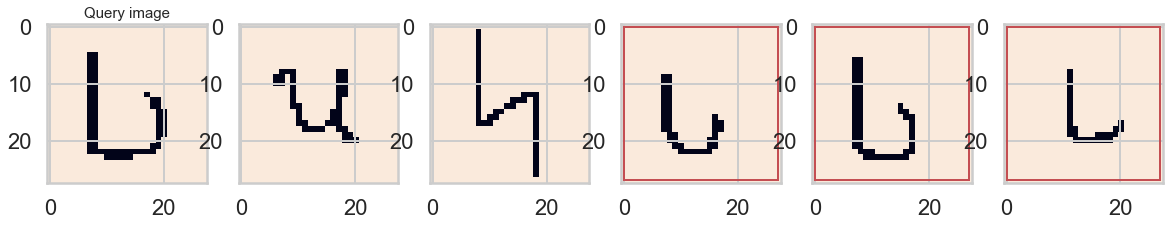

Truth: tensor([0, 0, 1, 1, 1])


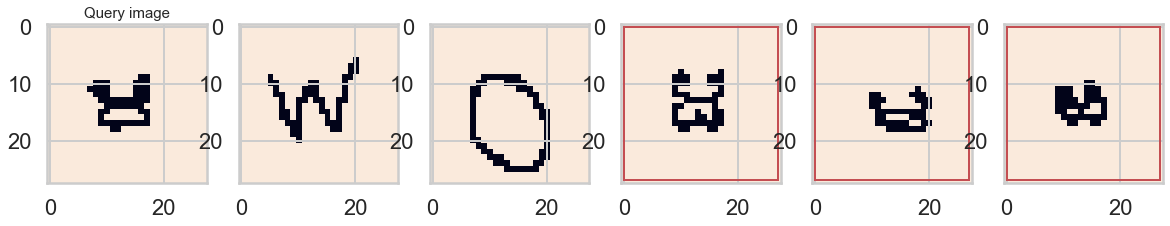

Truth: tensor([0, 0, 0, 1, 0])


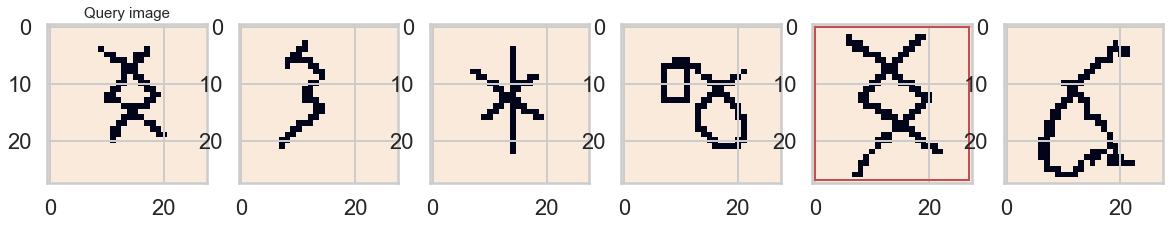

Truth: tensor([0, 0, 0, 1, 0])


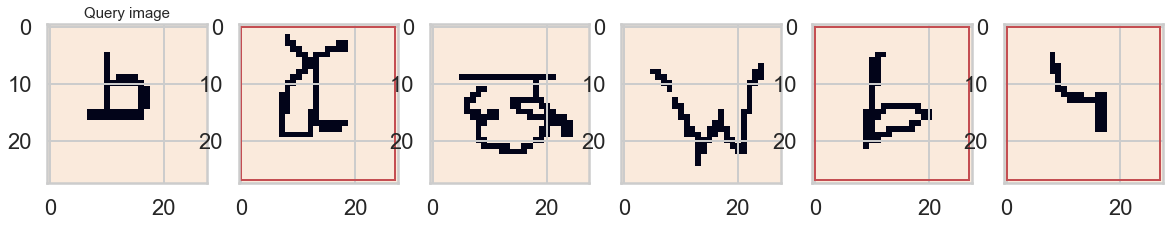

Truth: tensor([1, 0, 0, 0, 0])


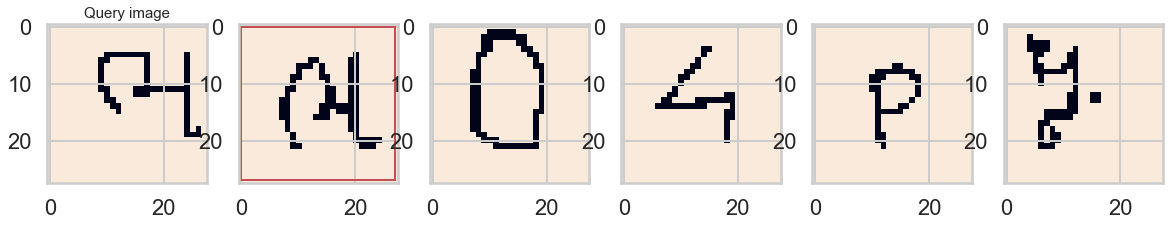

Truth: tensor([0, 1, 0, 0, 0])


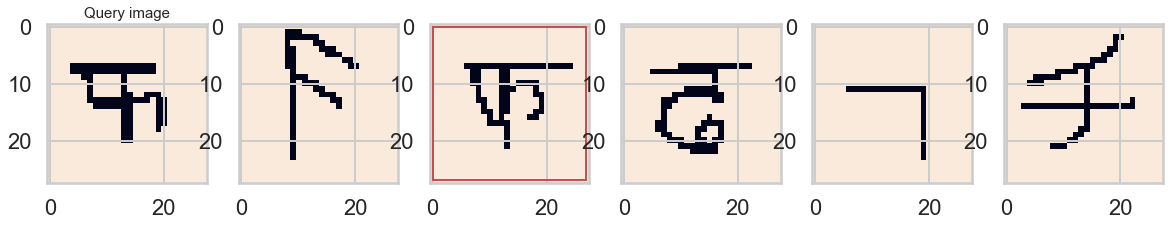

Truth: tensor([1, 0, 0, 1, 0])


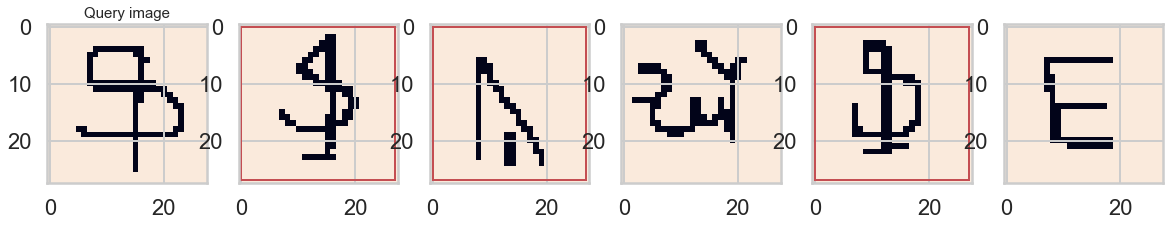

Truth: tensor([1, 0, 0, 1, 0])


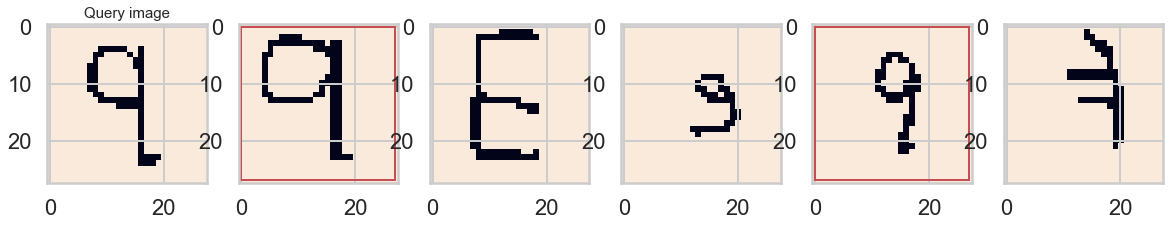

Truth: tensor([0, 1, 0, 1, 1])


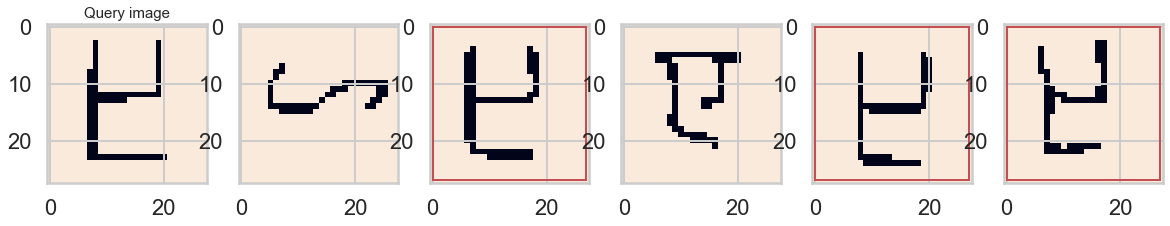

Truth: tensor([0, 0, 1, 1, 0])


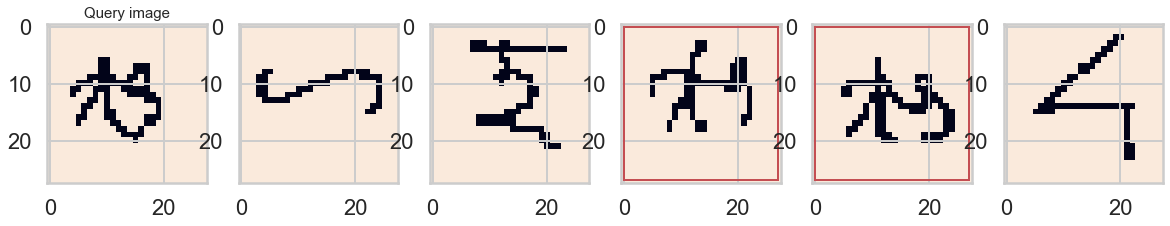

Truth: tensor([0, 1, 1, 0, 1])


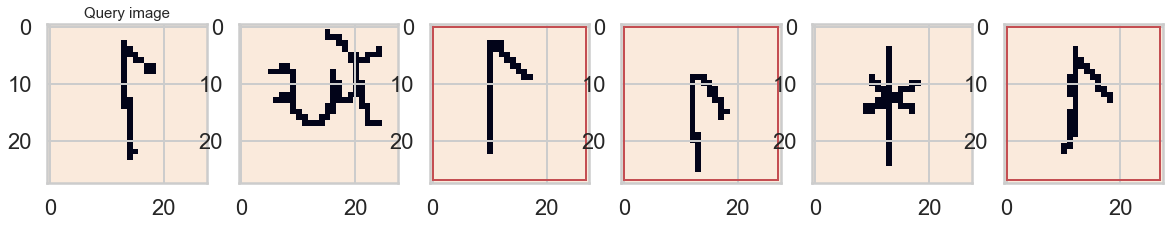

In [16]:
accuracy = []
precision = []
recall = []
plot_limit = 20
current_limit = 0

for batch in test_loader:
    for test_set in range(len(batch)):
        current_limit+=1
        
        # each batch contains several rows (row: support set and query) for the 1st elemnet
        images = [batch[0][test_set][i] for i in range(5)]
        query_image = batch[0][test_set][5]
        label = batch[1][test_set]
        
        query_image = query_image.to(device=device, dtype=torch.float)
        query_embedding = model.get_embedding(query_image)
        
        distances = []
        
        for image in images:
            image = image.to(device=device, dtype=torch.float)
            image_embedding = model.get_embedding(image)
            # similarity
            distance = (query_embedding - image_embedding).pow(2).sum(1)
            distances.append(distance.item())
        
        # FIRST OPTION OF THRESHOLD: maximum of all positive distances
        # get indexes of the positive images from the true labels
        positive_indexes = np.where(label == 1)[0]
        # get largest distance from images that are really positive (true labels) as threshold
        t = np.max([distances[i] for i in positive_indexes])
        
        # if distance is <= threshold set predicition to positive
        pred = [1 if distances[i] <= t else 0 for i in range(len(distances))]

        # Precision calculation
        tp=0
        fp=0
        fn=0
        
        for pred_index in range(len(pred)):
            # Calculate TP
            if pred[pred_index] == label[pred_index] and pred[pred_index] == 1:
                tp+=1
            # Calculate FP
            elif pred[pred_index] != label[pred_index] and pred[pred_index] == 1:
                fp+=1
                
        precision.append(tp/(tp+fp))

        # Recall calculation
        for pred_index in range(len(pred)):
            # Calculate FN
            if pred[pred_index] == label[pred_index] and pred[pred_index] == 0:
                fn+=1
                
        recall.append(tp/(tp+fn))
        
        # plotting positively predicted images
        pred_indexes = np.where(np.array(pred) == 1)[0]
        
        if current_limit <= plot_limit:
            print('Truth: '+str(label))
            f, axes = plt.subplots(1, len(images)+1, figsize=(20,5))
            axes[0].imshow(query_image.cpu())
            axes[0].set_title(f"Query image", fontsize=15)
            for i in range(len(images)):
                image = images[i].to(device=device, dtype=torch.float)
                axes[1+i].imshow(image.cpu())
                if i in pred_indexes:
                    axes[1+i].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
            plt.show()
        
        # get array with values 1 if match, else 0
        comparison = np.equal(pred, list(np.array(label)))
        # compute mean of matches, this gives accuracy for current support set and query
        accuracy.append(np.mean(comparison))

In [17]:
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1 score: {2 * np.mean(precision) * np.mean(recall) / (np.mean(precision) + np.mean(recall))}")

Accuracy: 0.965
Precision: 0.9488333333333333
Recall: 0.4129166666666667
F1 score: 0.5754200069355201


#### SECOND OPTION OF PREDICTION THRESHOLD: average of all distances

While the ideal threshold would be close to the maximum distance of all true positive images to the query image, this is often not achievable in a real-world scenario without having access to the true test labels. A more realistic threshold is the mean of all distances per set.

Truth: tensor([1, 1, 0, 1, 0])


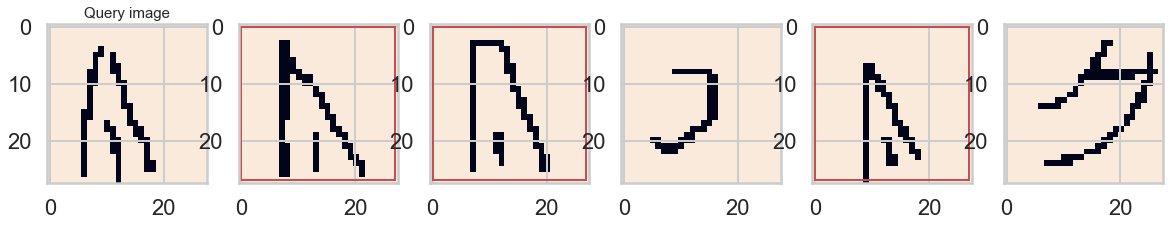

Truth: tensor([0, 1, 1, 0, 0])


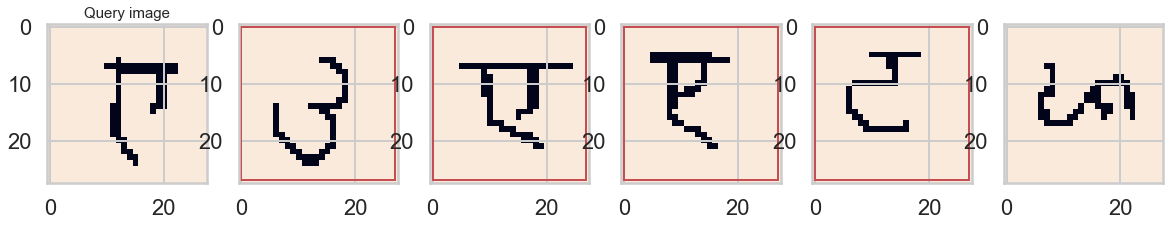

Truth: tensor([0, 0, 1, 1, 1])


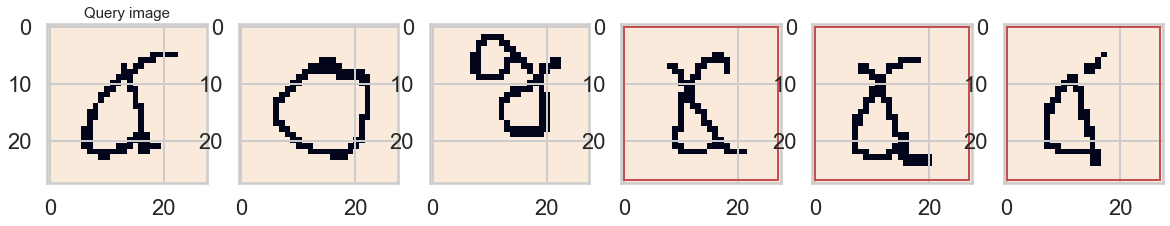

Truth: tensor([0, 1, 0, 1, 1])


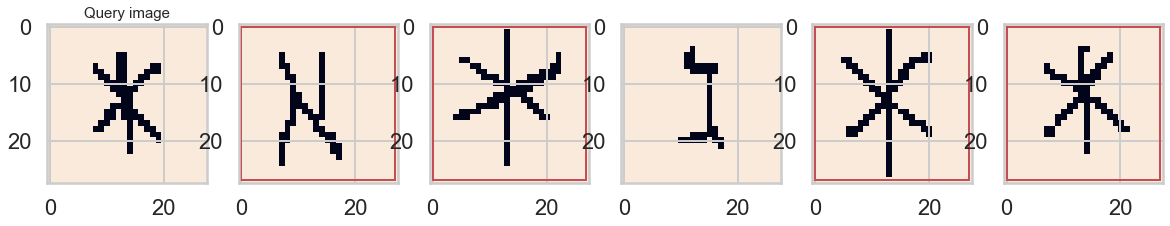

Truth: tensor([1, 0, 0, 0, 0])


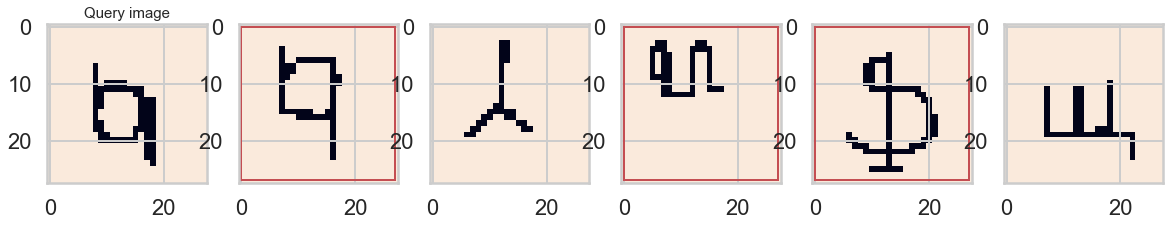

Truth: tensor([1, 0, 1, 1, 0])


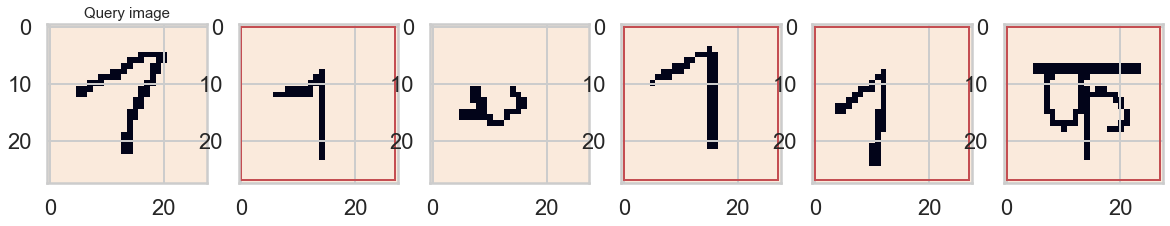

Truth: tensor([1, 0, 1, 0, 0])


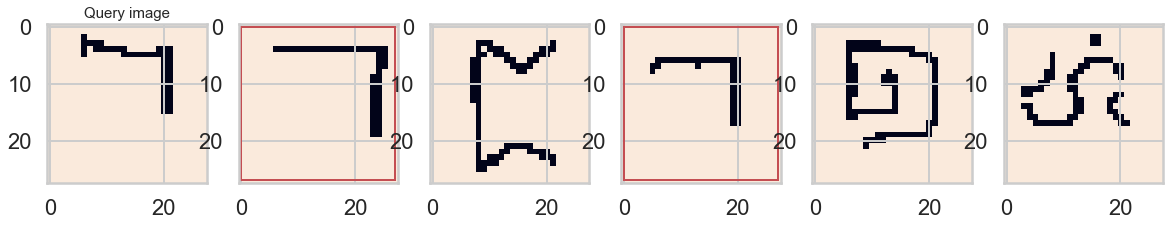

Truth: tensor([1, 1, 1, 0, 0])


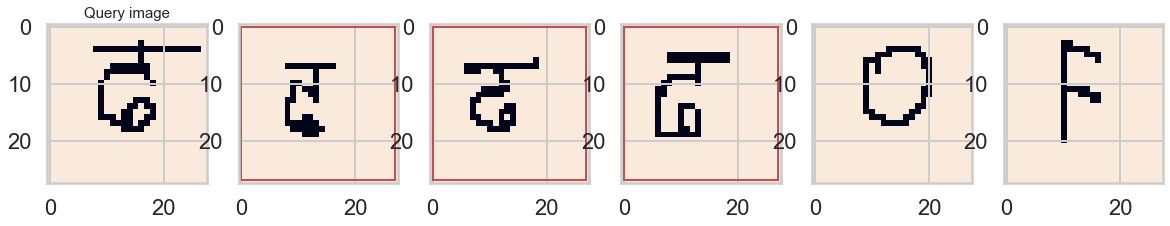

Truth: tensor([0, 0, 1, 0, 1])


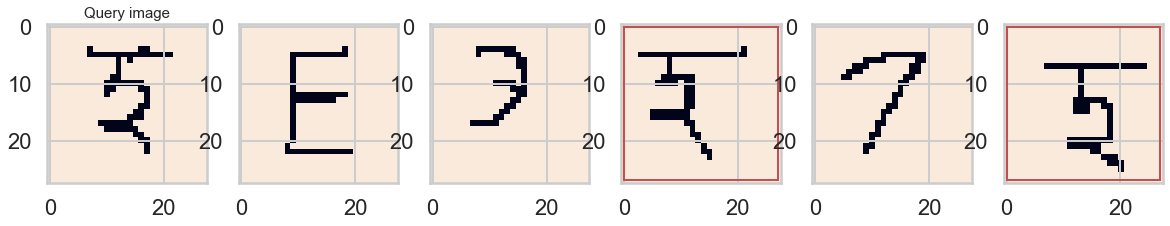

Truth: tensor([0, 0, 1, 1, 1])


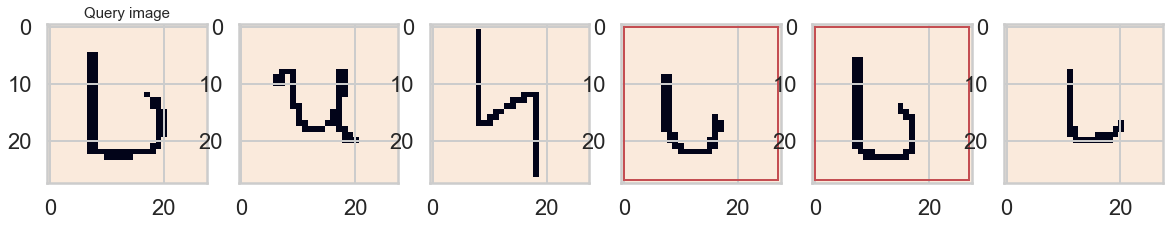

Truth: tensor([0, 0, 1, 1, 1])


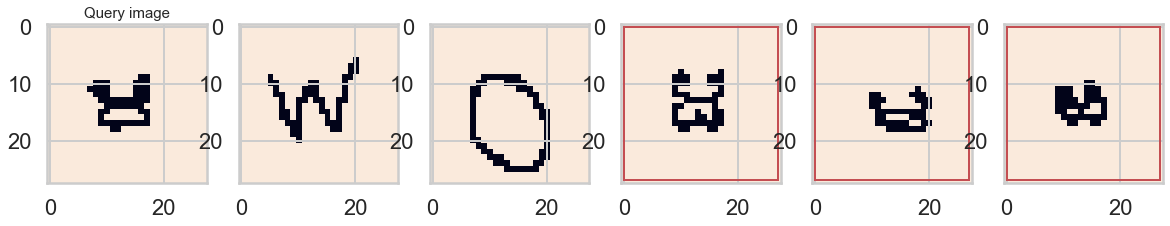

Truth: tensor([0, 0, 0, 1, 0])


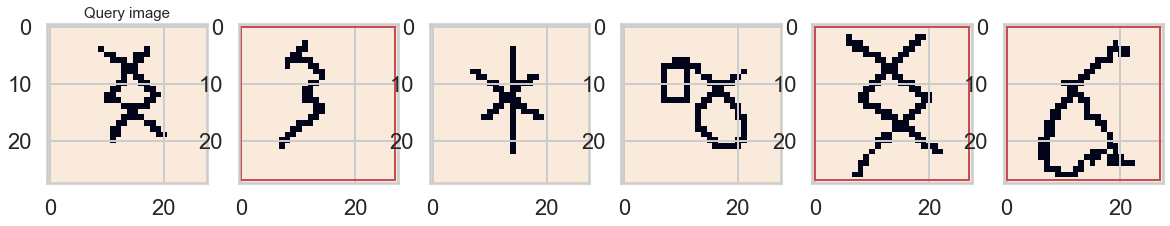

Truth: tensor([0, 0, 0, 1, 0])


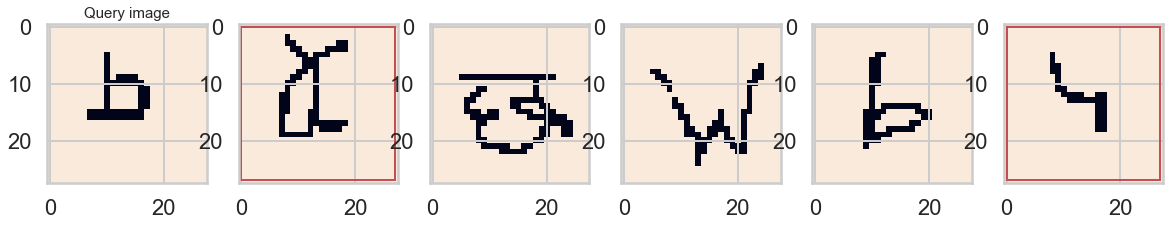

Truth: tensor([1, 0, 0, 0, 0])


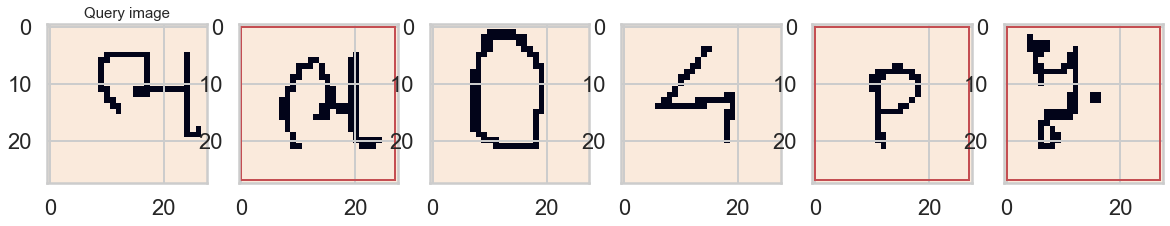

Truth: tensor([0, 1, 0, 0, 0])


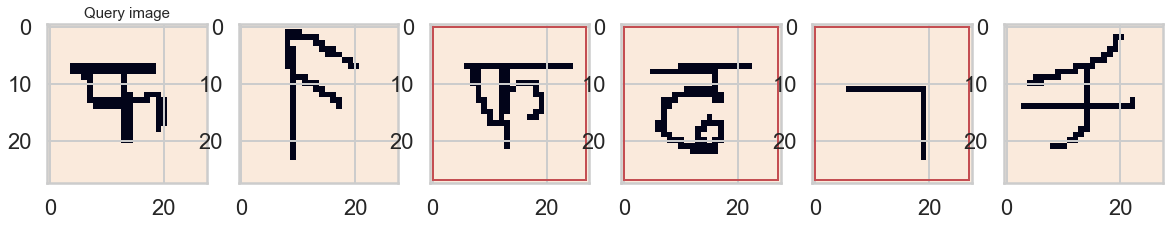

Truth: tensor([1, 0, 0, 1, 0])


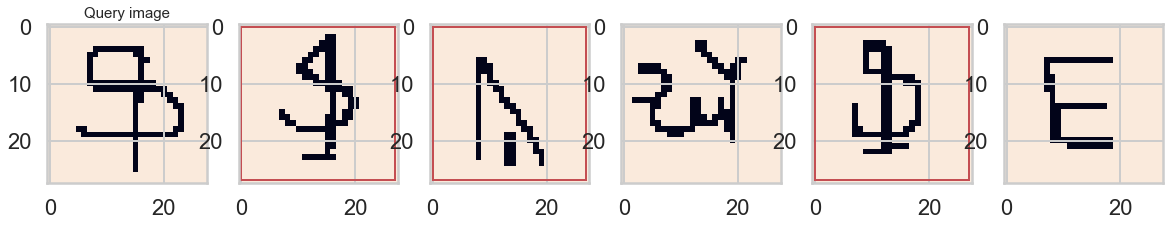

Truth: tensor([1, 0, 0, 1, 0])


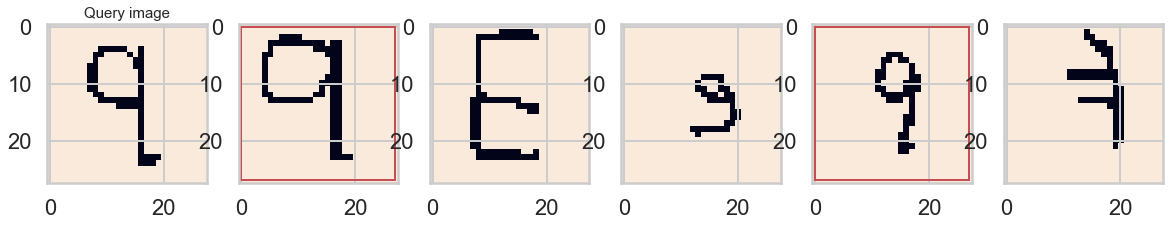

Truth: tensor([0, 1, 0, 1, 1])


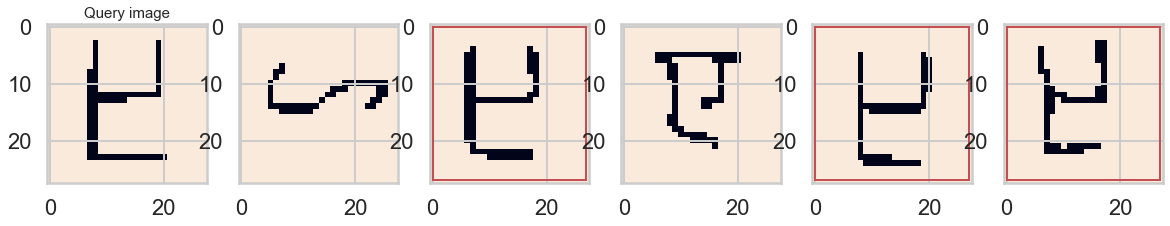

Truth: tensor([0, 0, 1, 1, 0])


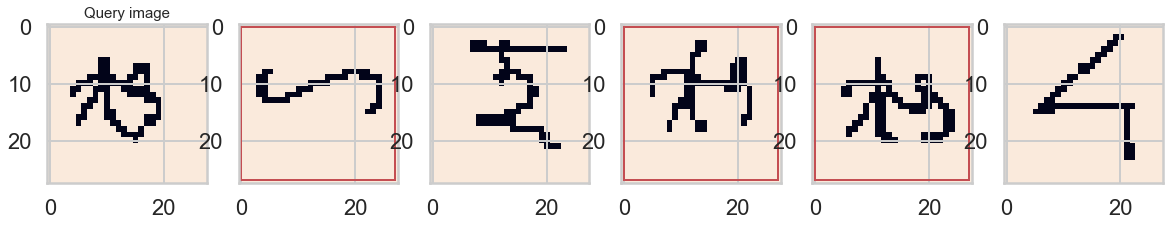

Truth: tensor([0, 1, 1, 0, 1])


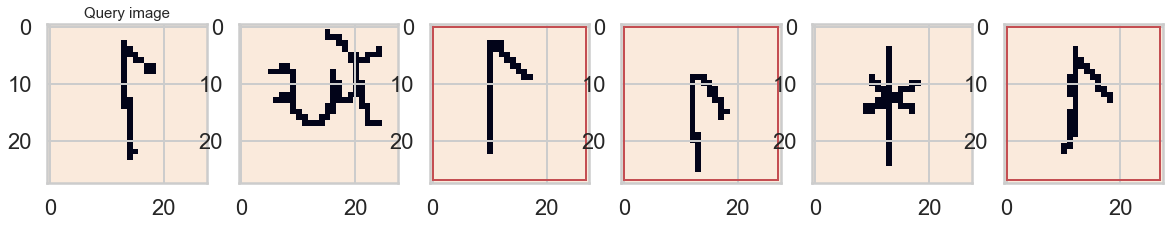

In [18]:
accuracy = []
precision = []
recall = []
plot_limit = 20
current_limit = 0

for batch in test_loader:
    for test_set in range(len(batch)):
        current_limit+=1
        
        # each batch contains several rows (row: support set and query) for the 1st elemnet
        images = [batch[0][test_set][i] for i in range(5)]
        query_image = batch[0][test_set][5]
        label = batch[1][test_set]
        
        query_image = query_image.to(device=device, dtype=torch.float)
        query_embedding = model.get_embedding(query_image)
        
        distances = []
        
        for image in images:
            image = image.to(device=device, dtype=torch.float)
            image_embedding = model.get_embedding(image)
            # similarity
            distance = (query_embedding - image_embedding).pow(2).sum(1)
            distances.append(distance.item())

        # SECOND OPTION OF THRESHOLD: average of all distances
        # get mean distance as threshold
        t = np.mean([distances[i] for i in range(len(distances))])
        
        # if distance is <= threshold set predicition to positive
        pred = [1 if distances[i] <= t else 0 for i in range(len(distances))]

        # Precision calculation
        tp=0
        fp=0
        fn=0
        
        for pred_index in range(len(pred)):
            # Calculate TP
            if pred[pred_index] == label[pred_index] and pred[pred_index] == 1:
                tp+=1
            # Calculate FP
            elif pred[pred_index] != label[pred_index] and pred[pred_index] == 1:
                fp+=1
                
        precision.append(tp/(tp+fp))

        # Recall calculation
        for pred_index in range(len(pred)):
            # Calculate FN
            if pred[pred_index] == label[pred_index] and pred[pred_index] == 0:
                fn+=1
                
        recall.append(tp/(tp+fn))
        
        # plotting positively predicted images
        pred_indexes = np.where(np.array(pred) == 1)[0]
        if current_limit <= plot_limit:
            print('Truth: '+str(label))
            f, axes = plt.subplots(1, len(images)+1, figsize=(20,5))
            axes[0].imshow(query_image.cpu())
            axes[0].set_title(f"Query image", fontsize=15)
            for i in range(len(images)):
                image = images[i].to(device=device, dtype=torch.float)
                axes[1+i].imshow(image.cpu())
                if i in pred_indexes:
                    axes[1+i].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
            plt.show()
        
        
        # get array with values 1 if match, else 0
        comparison = np.equal(pred, list(np.array(label)))
        # compute mean of matches, this gives accuracy for current support set and query
        accuracy.append(np.mean(comparison))

In [19]:
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Precision: {np.mean(precision)}")
print(f"Recall: {np.mean(recall)}")
print(f"F1 score: {2 * np.mean(precision) * np.mean(recall) / (np.mean(precision) + np.mean(recall))}")

Accuracy: 0.799
Precision: 0.68125
Recall: 0.4590833333333333
F1 score: 0.5485247369190295
